# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [4]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    return np.mean((y_true - y_predicted)**2)

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    return 1 - np.mean((y_true - y_predicted)**2) / np.std(y_pred)**2

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [5]:
class NormalLR:
    def __init__(self):
        self.X = None
        self.y = None
        self.w = None
        self.x_scaler = None
        self.y_scaler = None
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        n, dim = X.shape
        x_mins = np.amin(X, axis=0)
        x_maxs = np.amax(X, axis=0)
        self.x_scaler = x_mins, x_maxs
        X = (X - x_mins) / (x_maxs - x_mins)
        X1 = np.ones((n, dim + 1))
        X1[:, :-1] = X
        y_min = np.amin(y)
        y_max = np.amax(y)
        self.y_scaler = y_min, y_max
        y = (y - y_min) / (y_max - y_min)
        self.X = X1
        self.y = y
        self.w = np.linalg.solve(X1.T @ X1, X1.T @ y)
        
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        minx, maxx = self.x_scaler
        miny, maxy = self.y_scaler
        X = (X - minx) / (maxx - minx)
        n, dim = X.shape
        X1 = np.ones((n, dim + 1))
        X1[:, :-1] = X
        y = X1 @ self.w
        return y * (maxy - miny) + miny

In [8]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [9]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.008312622153421751, R2: 0.9988880108781877


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [18]:
class GradientLR:
    def __init__(self, alpha:float, iterations=10000, l=0.):
        self.X = None
        self.y = None
        self.w = None
        self.x_scaler = None
        self.y_scaler = None
        self.lr = alpha
        self.max_iter = iterations
        self.l = l
        
    def grad(self, w):
        X, y, l = self.X, self.y, self.l
        n = X.shape[0]
        return 2 / n * (X.T @ (X @ w - y)) + l * np.sign(w)
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        n, dim = X.shape
        x_mins = np.amin(X, axis=0)
        x_maxs = np.amax(X, axis=0)
        self.x_scaler = x_mins, x_maxs
        X = (X - x_mins) / (x_maxs - x_mins)
        X1 = np.ones((n, dim + 1))
        X1[:, :-1] = X
        y_min = np.amin(y)
        y_max = np.amax(y)
        self.y_scaler = y_min, y_max
        y = (y - y_min) / (y_max - y_min)
        self.X = X1
        self.y = y
        w = np.zeros((dim + 1, 1))
        cnt = 0
        alpha = self.lr
        while cnt < self.max_iter:
            cnt += 1
            w = w - alpha * self.grad(w)
        self.w = w
        
    def predict(self, X:np.ndarray):
        n, dim = X.shape
        minx, maxx = self.x_scaler
        miny, maxy = self.y_scaler
        X = (X - minx) / (maxx - minx)  
        X1 = np.ones((n, dim + 1))
        X1[:, :-1] = X
        y = X1 @ self.w
        return y * (maxy - miny) + miny

In [11]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [15]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

In [16]:
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

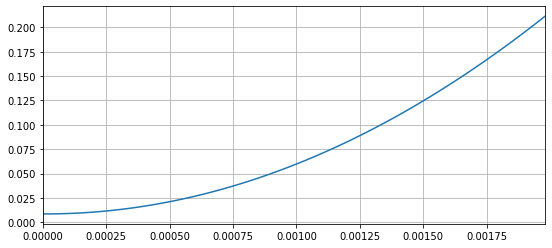

In [19]:
build_plot(X_train, y_train, X_val, y_val)

In [21]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.010211221135961908, R2: 0.9988859462543214


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [32]:
X, y = read_data()
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [33]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 20491219.288693957, R2: 0.6199268086547863


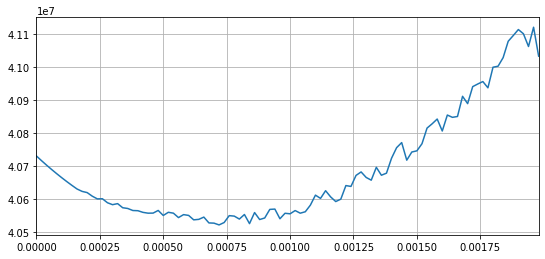

In [35]:
build_plot(X_train, y_train, X_val, y_val)

In [36]:
regr = GradientLR(0.1, iterations=10000, l=0.0007)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 20885097.71305337, R2: 0.5924938879458783


### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

In [37]:
regr.w

array([[-9.25669367e-02],
       [ 8.77519711e-02],
       [ 3.66382666e-05],
       [ 4.07416544e-02],
       [-1.43514943e-01],
       [ 4.73953131e-01],
       [ 2.74851226e-05],
       [-2.70624410e-01],
       [ 7.44140557e-02],
       [-8.11836482e-02],
       [-1.96405570e-01],
       [ 6.86239922e-02],
       [-4.01788768e-01],
       [ 4.53201074e-01]])

In [49]:
w = regr.w[:-1].reshape((1, -1))[0]
s = np.argsort(w)
s, np.sign(w[s])

(array([12,  7, 10,  4,  0,  9,  6,  2,  3, 11,  8,  1,  5]),
 array([-1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))

Из рассмотрения весов делаем вывод, что признаки оказвают разное влияние на среднюю стоимость жилья в районе (поседний признак -- смещение). Сильнее всего уменьшают стоимость жилья процент населения с низким статусом и удалённость от 5 деловых центров Бостона. Также негативно влияют на стоимость жилья (в порядке значимости) большое количество учеников на одного учителя, концентрация оксидов азота и уровень пресупности. Увеличивают среднюю стоимость жилья в районе (в порядке значимости): среднее число комнат в доме, процент частных владений площадью более 25000 кв. футов и индекс доступности автомагистралей. Остальные признаки оказывают незначительное влияние на цену жилья. 